In [1]:
import torch
import gpytorch
from tools import plot, plotarray, pretty_kernel
import numpy as np


seed = 40

# Set seeds for reproducibility
np.random.seed(seed)
torch.manual_seed(seed)

def make_y(x):
    noise = np.random.normal(0, 20, size=x.shape)
    y_2 = 1 * x**2 + 3.2 + 4 * x
    y_sin = np.sin(x * 3) * 50
    y = y_2 + y_sin + noise # Combine linear and quadratic components
    y *= 0.1

    return y

X_train = torch.linspace(-5, 5, 35, dtype=torch.float32)
y_train = torch.tensor(make_y(X_train.numpy()), dtype=torch.float32, requires_grad=False)

y_train_mean = y_train.mean()
y_train_std = y_train.std()
y_train = (y_train - y_train_mean) / y_train_std

X_test = torch.linspace(-7, 7, 200, dtype=torch.float32)
y_test = torch.tensor(make_y(X_test.numpy()), dtype=torch.float32, requires_grad=False)
y_test = (y_test - y_train_mean) / y_train_std

In [ ]:

# Define GP model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        
        # Learnable linear mean function: μ(x) = a·x + b
        self.mean_module = gpytorch.means.ConstantMean()
        
        # RBF kernel
        self.covar_module = gpytorch.kernels.ScaleKernel(
            # gpytorch.kernels.PolynomialKernel(power=2) 
            # + 
            gpytorch.kernels.PeriodicKernel(
                period_length_prior=gpytorch.priors.NormalPrior(0, 1),
                period_length_constraint=gpytorch.constraints.Interval(0, 10)
            )
            +
            gpytorch.kernels.RBFKernel(lengthscale_prior=gpytorch.priors.NormalPrior(0, 5))
        )
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# # Gaussian likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_prior=gpytorch.priors.NormalPrior(0, 5),
)

# Instantiate model
model = ExactGPModel(X_train, y_train, likelihood)
optimizer = torch.optim.Adam(model.parameters(), lr=0.5, amsgrad=False)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


## SAMPLING PRIOR
model.eval()
with torch.no_grad(), gpytorch.settings.prior_mode(True):
    prior = likelihood(model(X_test))
    mu_prior = prior.mean.numpy().view(plotarray)
    var = prior.variance
    std_prior = var.sqrt().numpy().view(plotarray)
    samples_prior = prior.sample(torch.Size([10])).numpy().view(plotarray)


## TRAINING
model.train()
likelihood.train()
for i in range(200):
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, y_train)
    loss.backward()
    optimizer.step()


## SAMPLING POSTERIOR
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred_train = likelihood(model(X_train))
    mu_train = pred_train.mean.numpy().view(plotarray)
    pred = likelihood(model(X_test))
    mu_s = pred.mean.numpy().view(plotarray)
    var = pred.variance
    std_s = var.sqrt().numpy().view(plotarray)

train_rmse = np.sqrt(np.mean((mu_train - y_train.numpy())**2))
test_rmse = np.sqrt(np.mean((mu_s - y_test.numpy())**2))

print(f"train RMSE: {train_rmse:.3f}")
print(f"test RMSE: {test_rmse:.3f}")

train RMSE: 0.012
test RMSE: 0.772


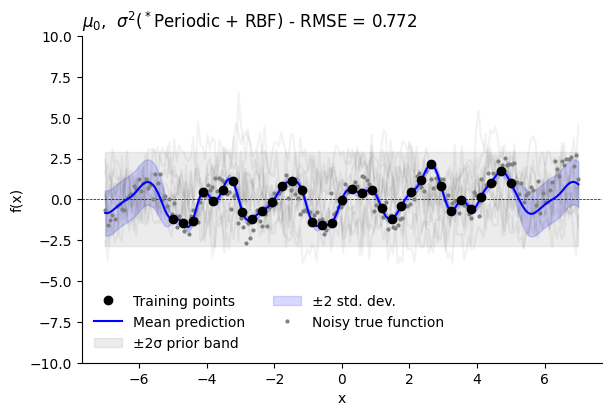

In [82]:
covar_pretty = pretty_kernel(model.covar_module, ScaleKernel='$^*$', **{'(': '', ')': ''}, Kernel='')
covar_string = pretty_kernel(model.covar_module, **{'(': '', ')': '', ' + ': '_'}, Kernel='', Scale='')

fig, ax = plot(X_train, y_train, X_test, mu_s, std_s, mu_prior, std_prior, samples_prior)
ax.plot(X_test.numpy(), y_test.numpy(), c='0.5', marker='.', ms=4, lw=0, label='Noisy true function')
ax.legend(ncol=2, frameon=False)
ax.set_fc('none')
ax.set_ylim(-10, 10)
ax.set_title(f"$\\mu_0$,  $\\sigma^2$({covar_pretty}) - RMSE = {test_rmse:.3f} ", loc='left')
# fig.savefig(f'./imgs/nonlinear_gpytorch-Scaled_{covar_string}.png', bbox_inches='tight', dpi=140)
print()